Playing around with data and code so will be unstructured. See [audio-main notebook]() for structure

Load and run main notebook to get `visual_features_paths` variable

In [1]:
main_notebook = 'main.ipynb'

In [2]:
%load main_notebook

In [3]:
%run 'main.ipynb'

In [4]:
ys = text_features_with_y.loc[0:, 'emotion_labels']
# ys

# Reduce dimensions

In [5]:
def load_text_features(text_features_paths, ys):
    """Reduce from 2D to 1D by removing the time dimension
    
    visual_features_paths -- list
    
    Return 
    reduced shapes of each input -- list
    """
    
    loaded_text_features = []
    true_labels = []
    
    for row in range(len(text_features_paths)):
        # print("Current path with files is: ", text_features_paths)
        path_exists = os.path.exists(text_features_paths[row])
        # print(path_exists)
        if path_exists == True:
            # print("Current path with files is: ", text_features_paths[row])
            load_text_features_file = np.load(text_features_paths[row])
            # print("  Original Shape: ", np.shape(load_text_features_file))
            # resampled_text = np.mean(load_text_features_file, axis=0)
            # print("  Reduced shape: ", np.shape(resampled_text))
            loaded_text_features.append(load_text_features_file)
            # print("  reduced_text_features: ", np.shape(reduced_text_features))
            true_labels.append(ys[row])
            # print()
        else:
            pass
            # print("CANNOT find current path: ", audio_features_path)
    return loaded_text_features, true_labels

In [6]:
loaded_text_features, true_labels = load_text_features(text_features_paths, ys)
np.shape(loaded_text_features), np.shape(true_labels)

((1336, 768), (1336,))

# Split Datasets into Train, Validate, Test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(loaded_text_features, true_labels, test_size=0.7, random_state=42)
total_X = len(X_train) + len(X_test)
total_Y = len(y_train) + len(y_test)
len(X_train), len(X_test), len(y_train), len(y_test), total_X, total_Y

(400, 936, 400, 936, 1336, 1336)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.7, random_state=42)
total_X = len(X_train) + len(X_val)
total_Y = len(y_train) + len(y_val)
len(X_train), len(X_val), len(y_train), len(y_val), total_X, total_Y, np.shape(X_train), np.shape(y_train)

(120, 280, 120, 280, 400, 400, (120, 768), (120,))

# Before Hyper-Parameter Tuning

- `CategoricalNB()` and `ComplementNB()` NOT able to process negative `X_train` values. Why?
- How do I know which to use out of `BernoulliNB()` and `GaussianNB()`? Test both when doing hyper-parameter tuning to see which is returned. See GridSearchcv Classification for Multiple Model: https://machinelearninghd.com/gridsearchcv-classification-hyper-parameter-tuning/


0.5053418803418803
0.5096153846153846


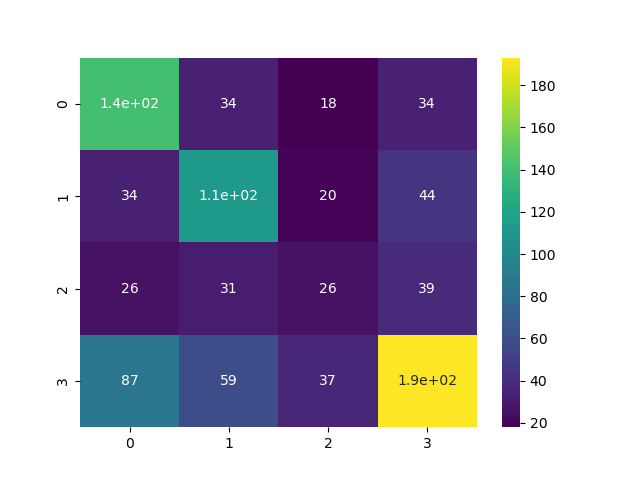

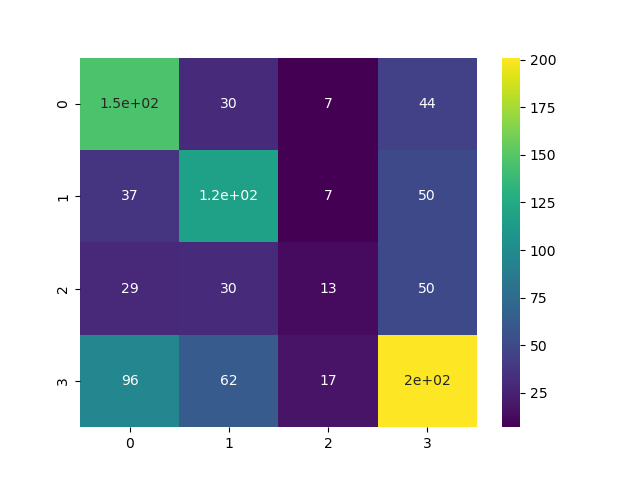

In [9]:
bernoulli_without_hp = naive_bayes.BernoulliNB()
bernoulli_train_without_hp = bernoulli_without_hp.fit(X_train, y_train)
bernoulli_test_without_hp = bernoulli_train_without_hp.score(X_test, y_test)
print(bernoulli_test_without_hp)
bernoulli_y_pred_without_hp = bernoulli_train_without_hp.predict(X_test)


gaussian_without_hp = naive_bayes.GaussianNB()
gaussian_train_without_hp = gaussian_without_hp.fit(X_train, y_train)
gaussian_test_without_hp = gaussian_train_without_hp.score(X_test, y_test)
print(gaussian_test_without_hp)
gaussian_y_pred_without_hp = gaussian_train_without_hp.predict(X_test)


bernoulli_cm = confusion_matrix(y_test, bernoulli_y_pred_without_hp)
sns.heatmap(bernoulli_cm, annot=True, cmap='viridis')
plt.show()

gaussian_cm = confusion_matrix(y_test, gaussian_y_pred_without_hp)
sns.heatmap(gaussian_cm, annot=True, cmap='viridis')
plt.show()

In [10]:
print(classification_report(y_test, bernoulli_y_pred_without_hp))
print(classification_report(y_test, gaussian_y_pred_without_hp))

              precision    recall  f1-score   support

           0       0.49      0.62      0.55       227
           1       0.48      0.54      0.50       211
           2       0.26      0.21      0.23       122
           3       0.62      0.51      0.56       376

    accuracy                           0.51       936
   macro avg       0.46      0.47      0.46       936
weighted avg       0.51      0.51      0.50       936

              precision    recall  f1-score   support

           0       0.47      0.64      0.55       227
           1       0.49      0.55      0.52       211
           2       0.30      0.11      0.16       122
           3       0.58      0.53      0.56       376

    accuracy                           0.51       936
   macro avg       0.46      0.46      0.44       936
weighted avg       0.50      0.51      0.49       936



# After Hyper-Parameter Tuning

In [11]:
# estimators are BernoulliNB() and GaussianNB()
classifiers = {
    "Bernoulli Estimator": naive_bayes.BernoulliNB(),
    "Gaussian Estimator": naive_bayes.GaussianNB()
    
}

from time import time
nfast = 14      # Don't run the very slow ones
head = list(classifiers.items())[:nfast]

for name, classifier in head:
    start = time()
    classifier.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    score = classifier.score(X_test, y_test)
    score_time = time()-start
    print("{:<15}| score = {:.3f} | time = {:,.3f}s/{:,.3f}s".format(name, score, train_time, score_time))

Bernoulli Estimator| score = 0.505 | time = 0.007s/0.028s
Gaussian Estimator| score = 0.510 | time = 0.003s/0.033s


In [12]:
naive_bayes.BernoulliNB().get_params().keys()

dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior'])

In [13]:
bernoulli_classifier = naive_bayes.BernoulliNB()
bernoulli_param_grid = {
    'alpha': [0.01, 0.1, 10, 100],
    'binarize': [0.01, 0.1, 10, 100],
    # 'class_prior': [0, 1, 2, 3],
    # 'class_prior': [4],
    'fit_prior': [True, False]
}

bernoulli_classification = GridSearchCV(bernoulli_classifier, param_grid=bernoulli_param_grid, cv=10)
bernoulli_classification

GridSearchCV(cv=10, estimator=BernoulliNB(),
             param_grid={'alpha': [0.01, 0.1, 10, 100],
                         'binarize': [0.01, 0.1, 10, 100],
                         'fit_prior': [True, False]})

In [14]:
naive_bayes.GaussianNB().get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [15]:
gaussian_classifier = naive_bayes.GaussianNB()
gaussian_param_grid = {
    # 'priors': [0, 1, 2, 3],
    # 'priors': [4],
    'var_smoothing': [True, False]
}

gaussian_classification = GridSearchCV(gaussian_classifier, param_grid=gaussian_param_grid, cv=10)
gaussian_classification

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': [True, False]})

In [16]:
bernoulli_classification.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BernoulliNB(),
             param_grid={'alpha': [0.01, 0.1, 10, 100],
                         'binarize': [0.01, 0.1, 10, 100],
                         'fit_prior': [True, False]})

In [17]:
gaussian_classification.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': [True, False]})

In [18]:

print(gaussian_classification.best_estimator_)

GaussianNB(var_smoothing=False)


In [21]:
def get_info(estimator, y_pred_without_hp):
    
    estimator.fit(X_train, y_train)
    print("Accuracy:"+ str(estimator.score(X_train, y_train))) 
    
    # train the model with hyperparameter tuning on all permutation parameters
    train_with_hp = estimator.fit(X_train, y_train)
    # train_with_hp

    all_hp_results = train_with_hp.cv_results_
    all_hp_results_df = pd.DataFrame(all_hp_results)

    print("[INFO] the hyper-parameters results are...")
    # all_hp_results_df

    print("[INFO] the best hyper-parameters results are...")
    # show the best estimator
    best_params = train_with_hp.best_params_
    print(best_params)

    print("\n[INFO] evaluating on VALIDATION...")
    # evaluate on the best model with hyperparameter tuning model
    # validation_with_hp = train_with_hp.score(X_test, y_test)
    validation_with_hp = train_with_hp.score(X_val, y_val)
    print(validation_with_hp)

    """
    How to use validation set? We're getting a score but shouldn't we update our model with validation, then get the score on test?
    """
    print("\n[INFO] the best score...")
    # show the best score
    print(train_with_hp.best_score_)

    print("[INFO] classification on TEST...")
    # make a prediction (returns a list of 0 - 4 values)
    y_pred_with_hp = train_with_hp.predict(X_test)

    # show true labels and predictions
    cm = confusion_matrix(y_test, y_pred_with_hp)
    sns.heatmap(cm, annot=True, cmap='viridis')
    plt.show()

    print(classification_report(y_test, y_pred_with_hp))

    visual_f1_micro = f1_score(y_test, y_pred_without_hp, average='micro')
    visual_f1_micro

Accuracy:0.875
[INFO] the hyper-parameters results are...
[INFO] the best hyper-parameters results are...
{'alpha': 0.01, 'binarize': 0.01, 'fit_prior': True}

[INFO] evaluating on VALIDATION...
0.49642857142857144

[INFO] the best score...
0.4916666666666667
[INFO] classification on TEST...


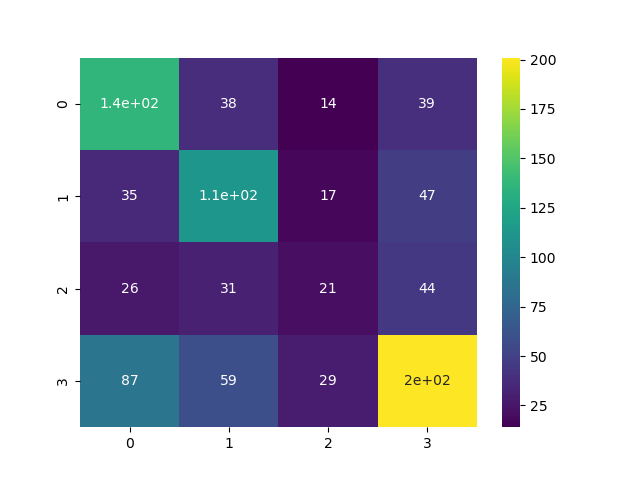

              precision    recall  f1-score   support

           0       0.48      0.60      0.53       227
           1       0.47      0.53      0.50       211
           2       0.26      0.17      0.21       122
           3       0.61      0.53      0.57       376

    accuracy                           0.50       936
   macro avg       0.45      0.46      0.45       936
weighted avg       0.50      0.50      0.50       936



In [22]:
get_info(bernoulli_classification, bernoulli_y_pred_without_hp)

Accuracy:0.9166666666666666
[INFO] the hyper-parameters results are...
[INFO] the best hyper-parameters results are...
{'var_smoothing': False}

[INFO] evaluating on VALIDATION...
0.5428571428571428

[INFO] the best score...
0.55
[INFO] classification on TEST...


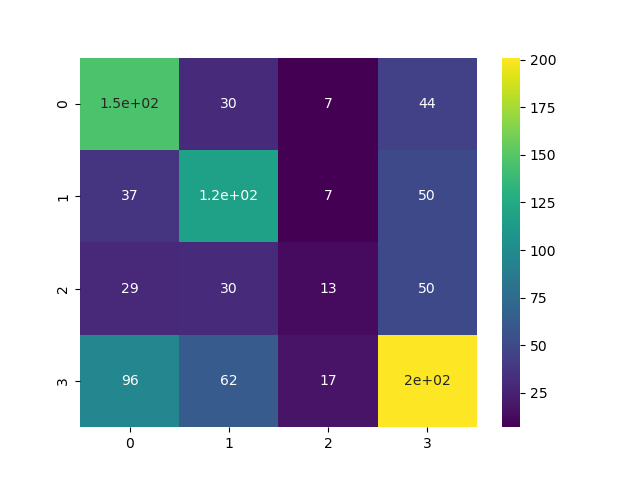

              precision    recall  f1-score   support

           0       0.47      0.64      0.55       227
           1       0.49      0.55      0.52       211
           2       0.30      0.11      0.16       122
           3       0.58      0.53      0.56       376

    accuracy                           0.51       936
   macro avg       0.46      0.46      0.44       936
weighted avg       0.50      0.51      0.49       936



In [23]:
get_info(gaussian_classification, gaussian_y_pred_without_hp)

In [24]:
train_with_hp = bernoulli_classification.fit(X_train, y_train)
text_b_y_pred_with_hp = train_with_hp.predict(X_test)
text_b_y_pred_with_hp

array([3, 1, 1, 0, 0, 3, 0, 0, 1, 1, 0, 3, 3, 0, 0, 3, 3, 2, 1, 2, 1, 3,
       1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 0, 2, 3, 1, 0, 0, 3, 0, 3, 2,
       1, 0, 1, 3, 3, 0, 3, 2, 0, 0, 1, 3, 0, 0, 1, 1, 1, 3, 0, 0, 3, 3,
       0, 0, 0, 0, 0, 3, 3, 0, 3, 2, 1, 1, 2, 0, 3, 3, 0, 0, 0, 0, 3, 0,
       1, 2, 0, 1, 0, 3, 1, 3, 1, 3, 0, 2, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3,
       1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3,
       3, 0, 0, 3, 1, 3, 3, 1, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 0,
       3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1,
       3, 1, 1, 1, 1, 0, 0, 3, 0, 3, 1, 3, 1, 0, 3, 1, 2, 3, 1, 1, 0, 0,
       3, 3, 3, 1, 3, 0, 0, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 3, 2, 0, 3, 0,
       0, 0, 3, 0, 2, 0, 3, 0, 3, 1, 1, 3, 1, 0, 0, 2, 1, 0, 2, 3, 1, 3,
       2, 3, 3, 2, 3, 0, 0, 3, 0, 1, 3, 3, 2, 3, 0, 1, 3, 0, 3, 3, 1, 3,
       2, 3, 0, 3, 3, 0, 1, 0, 0, 3, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 0, 3,
       0, 3, 3, 3, 3, 1, 3, 1, 0, 2, 3, 0, 3, 3, 3,

In [25]:
train_with_hp = gaussian_classification.fit(X_train, y_train)
text_g_y_pred_with_hp = train_with_hp.predict(X_test)
text_g_y_pred_with_hp

array([3, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 3, 3, 3, 1, 1, 1, 3,
       1, 3, 3, 3, 3, 2, 3, 1, 3, 1, 1, 0, 0, 2, 3, 1, 1, 0, 3, 3, 3, 2,
       1, 0, 1, 3, 3, 1, 0, 3, 0, 0, 1, 3, 0, 0, 1, 1, 1, 3, 0, 0, 3, 3,
       0, 0, 0, 0, 0, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 3, 0,
       1, 3, 0, 0, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3,
       1, 0, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 0, 1, 1, 1, 3, 1, 0, 3, 3, 3,
       1, 0, 0, 3, 1, 3, 3, 1, 0, 0, 0, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 1,
       3, 0, 3, 0, 1, 3, 0, 2, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 3, 1,
       3, 0, 1, 1, 1, 0, 0, 3, 0, 3, 1, 3, 1, 0, 3, 1, 2, 3, 1, 1, 3, 0,
       3, 3, 3, 1, 3, 0, 3, 1, 3, 0, 3, 1, 1, 3, 3, 1, 0, 3, 2, 0, 3, 0,
       0, 0, 3, 0, 2, 0, 3, 0, 3, 1, 0, 3, 2, 0, 0, 1, 1, 0, 3, 1, 1, 3,
       3, 3, 3, 2, 3, 0, 0, 3, 0, 3, 3, 3, 3, 0, 0, 1, 3, 0, 3, 3, 0, 0,
       2, 3, 0, 0, 3, 0, 1, 0, 0, 3, 0, 3, 2, 1, 0, 0, 0, 1, 2, 3, 0, 3,
       0, 3, 3, 3, 3, 1, 3, 1, 0, 2, 3, 0, 3, 3, 1,